In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis

#!conda install -c conda-forge bs4 --yes
from bs4 import BeautifulSoup

import json

#!mamba install -c conda-forge html5lib --yes
# import html5lib
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

import requests # library to handle requests
from pandas.io.json import json_normalize

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt

import seaborn as sns

# import k-means from clustering stage
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN 
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

%matplotlib inline

print('Libraries imported.')

Libraries imported.


### Data Acquisition from Wikipedia

In [2]:
wiki_url = "http://en.wikipedia.org/wiki/Planning_Areas_of_Singapore"

page = requests.get(wiki_url)
soup = BeautifulSoup(page.content, 'html.parser')

headings = ['Name (English)','Malay','Chinese', 'Pinyin','Tamil','Region','Area','Population','Density (/km2)']

wiki_table = soup.find('table', class_= "wikitable sortable")

data = {'Name(English)':[],'Malay':[],'Chinese':[], 'Pinyin':[],'Tamil':[],'Region':[],'Area':[],'Population':[],'Density(/km2)':[]}

rows = wiki_table.find_all('tr')

#print('number of rows: {}'.format(len(rows)))

row_marker = 0
for row in rows:
    column_marker = 0
    columns = row.find_all('td')
    for key, column in zip(data,columns):
        check = column.get_text()
        data[key].append(check[:-1])

df_plan_areas = pd.DataFrame(data)
df_plan_areas.head(10)

,Name(English),Malay,Chinese,Pinyin,Tamil,Region,Area,Population,Density(/km2)
0,Ang Mo Kio,,宏茂桥,Hóng mào qiáo,ஆங் மோ கியோ,North-East,13.94,"163,950","13,400"
1,Bedok,*,勿洛,Wù luò,பிடோக்,East,21.69,"279,380","13,000"
2,Bishan,,碧山,Bì shān,பீஷான்,Central,7.62,"88,010","12,000"
3,Boon Lay,,文礼,Wén lǐ,பூன் லே,West,8.23,30,3.6
4,Bukit Batok,*,武吉巴督,Wǔjí bā dū,புக்கிட் பாத்தோக்,West,11.13,"153,740","14,000"
5,Bukit Merah,*,红山,Hóng shān,புக்கிட் மேரா,Central,14.34,"151,980","11,000"
6,Bukit Panjang,*,武吉班让,Wǔjí bān ràng,பக்கிட் பஞ்சாங்,West,8.99,"139,280","15,000"
7,Bukit Timah,*,武吉知马,Wǔjí zhī mǎ,புக்கித் திமா,Central,17.53,"77,430","4,400"
8,Central Water Catchment,Kawasan Tadahan Air Tengah,中央集水区,Zhōngyāng jí shuǐ qū,மத்திய நீர் நீர்ப்பிடிப்பு,North,37.15,*,*
9,Changi,*,樟宜,Zhāng yí,சாங்கி,East,40.61,"1,830",80.62


In [3]:
df_mrt_stns= pd.read_html("https://en.wikipedia.org/wiki/List_of_Singapore_MRT_stations", flavor='bs4', header=0)[1]
df_mrt_stns.head()

,Alpha-numeric code(s),Alpha-numeric code(s).1,Station name,Station name.1,Station name.2,Opening,Name(s) during planning stages,Abbreviation,Location(s),Connection(s) to other transport
0,In operation,Future,English • Malay,Chinese,Tamil,Opening,Name(s) during planning stages,Abbreviation,Location(s),Connection(s) to other transport
1,North South Line (NSL),North South Line (NSL),North South Line (NSL),North South Line (NSL),North South Line (NSL),North South Line (NSL),North South Line (NSL),North South Line (NSL),North South Line (NSL),North South Line (NSL)
2,NS1 EW24,JE5,Jurong East,裕廊东,ஜூரோங் கிழக்கு,10 March 1990,Jurong East,JUR,Jurong East,Jurong East Temporary Bus Interchange
3,NS2,NaN,Bukit Batok,武吉巴督,புக்கிட் பாத்தோக்,10 March 1990,Bukit Batok South,BBT,Bukit Batok,Bukit Batok Bus Interchange
4,NS3,NaN,Bukit Gombak,武吉甘柏,புக்கிட் கோம்பாக்,10 March 1990,Bukit Batok North,BGB,Bukit Batok,NaN


In [4]:
df_mrt_stns2 = df_mrt_stns.drop(df_mrt_stns.index[[0,1]]).reset_index(drop=True)
df_mrt_stns3 = df_mrt_stns2.drop(columns=['Station name.1','Station name.2','Opening','Name(s) during planning stages','Abbreviation'])
df_mrt_stns3.columns = ['Existing Station Codes','Future Station Codes','Station Name','Towns','Connecting Transport Interchange']
df_mrt_stns3 = df_mrt_stns3.dropna(subset=['Existing Station Codes'])
df_mrt_stns3 = df_mrt_stns3[df_mrt_stns3['Existing Station Codes']!=df_mrt_stns3['Future Station Codes']]
df_mrt_stns4 = df_mrt_stns3[['Station Name','Towns','Existing Station Codes', 'Future Station Codes','Connecting Transport Interchange']]
df_mrt_stns4.head(50)

,Station Name,Towns,Existing Station Codes,Future Station Codes,Connecting Transport Interchange
0,Jurong East,Jurong East,NS1 EW24,JE5,Jurong East Temporary Bus Interchange
1,Bukit Batok,Bukit Batok,NS2,NaN,Bukit Batok Bus Interchange
2,Bukit Gombak,Bukit Batok,NS3,NaN,NaN
4,Choa Chu Kang,Choa Chu Kang,NS4 BP1,JS1,Choa Chu Kang Bus Interchange
5,Yew Tee,Choa Chu Kang,NS5,NaN,NaN
7,Kranji,Sungei Kadut,NS7,NaN,NaN
8,Marsiling,Woodlands,NS8,NaN,NaN
9,Woodlands,Woodlands,NS9 TE2,NaN,Woodlands Temporary Bus Interchange
10,Admiralty,Woodlands,NS10,NaN,NaN
11,Sembawang,Sembawang,NS11,NaN,Sembawang Bus Interchange


### Reshaping the table

In [5]:
# Dropping not-needed columns, 
df_plan_areas2 = df_plan_areas.drop(columns=["Malay", "Chinese", "Pinyin", "Tamil",'Density(/km2)'])
#renaming columns
df_plan_areas2.columns = ['Towns','Region','Town Area Coverage (km2)','Population']
df_plan_areas2 = df_plan_areas2.replace({'Population':{'\*':'0',',':''}},regex=True)
df_plan_areas3 = df_plan_areas2.astype({'Town Area Coverage (km2)':'float64','Population':'int64'})
df_plan_areas3[['Population']] = df_plan_areas3[['Population']].replace(0,df_plan_areas3[['Population']].mean()).astype('int64')

df_plan_areas3.head(10)

,Towns,Region,Town Area Coverage (km2),Population
0,Ang Mo Kio,North-East,13.94,163950
1,Bedok,East,21.69,279380
2,Bishan,Central,7.62,88010
3,Boon Lay,West,8.23,30
4,Bukit Batok,West,11.13,153740
5,Bukit Merah,Central,14.34,151980
6,Bukit Panjang,West,8.99,139280
7,Bukit Timah,Central,17.53,77430
8,Central Water Catchment,North,37.15,73203
9,Changi,East,40.61,1830


In [6]:
df_merge = pd.merge(left=df_mrt_stns4, right = df_plan_areas3, left_on = 'Towns', right_on = 'Towns')
df_merge

,Station Name,Towns,Existing Station Codes,Future Station Codes,Connecting Transport Interchange,Region,Town Area Coverage (km2),Population
0,Jurong East,Jurong East,NS1 EW24,JE5,Jurong East Temporary Bus Interchange,West,17.83,79240
1,Jurong East,Jurong East,EW24 NS1,JE5,Jurong East Bus Interchange,West,17.83,79240
2,Chinese Garden,Jurong East,EW25,NaN,NaN,West,17.83,79240
3,Jurong East,Jurong East,NS1 EW24,JE5,Jurong East Bus Interchange,West,17.83,79240
4,Bukit Batok,Bukit Batok,NS2,NaN,Bukit Batok Bus Interchange,West,11.13,153740
...,...,...,...,...,...,...,...,...
120,King Albert Park,Bukit Timah,DT6,NaN,NaN,Central,17.53,77430
121,Sixth Avenue,Bukit Timah,DT7,NaN,NaN,Central,17.53,77430
122,Tan Kah Kee,Bukit Timah,DT8,NaN,NaN,Central,17.53,77430
123,Rochor,Rochor,DT13,NaN,NaN,Central,1.62,13340


In [7]:
df_merge2 = df_merge.drop_duplicates(subset=['Station Name'],keep='last').reset_index(drop=True)
df_merge2
#df_merge2["Population per Station"]=df_merge2.Population/df_merge2.Towns.value_counts()

,Station Name,Towns,Existing Station Codes,Future Station Codes,Connecting Transport Interchange,Region,Town Area Coverage (km2),Population
0,Chinese Garden,Jurong East,EW25,NaN,NaN,West,17.83,79240
1,Jurong East,Jurong East,NS1 EW24,JE5,Jurong East Bus Interchange,West,17.83,79240
2,Bukit Batok,Bukit Batok,NS2,NaN,Bukit Batok Bus Interchange,West,11.13,153740
3,Bukit Gombak,Bukit Batok,NS3,NaN,NaN,West,11.13,153740
4,Yew Tee,Choa Chu Kang,NS5,NaN,NaN,West,6.11,190890
...,...,...,...,...,...,...,...,...
92,King Albert Park,Bukit Timah,DT6,NaN,NaN,Central,17.53,77430
93,Sixth Avenue,Bukit Timah,DT7,NaN,NaN,Central,17.53,77430
94,Tan Kah Kee,Bukit Timah,DT8,NaN,NaN,Central,17.53,77430
95,Rochor,Rochor,DT13,NaN,NaN,Central,1.62,13340


In [8]:
df_merge3 = df_merge2
df_merge3['Station(s) per Town'] = df_merge3['Towns'].map(df_merge2['Towns'].value_counts())
df_merge3['Crowd Density'] = (df_merge3['Population']/df_merge3['Town Area Coverage (km2)'])/df_merge3['Station(s) per Town']
df_merge3.head(20)

,Station Name,Towns,Existing Station Codes,Future Station Codes,Connecting Transport Interchange,Region,Town Area Coverage (km2),Population,Station(s) per Town,Crowd Density
0,Chinese Garden,Jurong East,EW25,NaN,NaN,West,17.83,79240,2,2222.097588
1,Jurong East,Jurong East,NS1 EW24,JE5,Jurong East Bus Interchange,West,17.83,79240,2,2222.097588
2,Bukit Batok,Bukit Batok,NS2,NaN,Bukit Batok Bus Interchange,West,11.13,153740,2,6906.558850
3,Bukit Gombak,Bukit Batok,NS3,NaN,NaN,West,11.13,153740,2,6906.558850
4,Yew Tee,Choa Chu Kang,NS5,NaN,NaN,West,6.11,190890,2,15621.112930
5,Choa Chu Kang,Choa Chu Kang,NS4 BP1,JS1,Choa Chu Kang Bus Interchange,West,6.11,190890,2,15621.112930
6,Kranji,Sungei Kadut,NS7,NaN,NaN,North,15.99,780,1,48.780488
7,Marsiling,Woodlands,NS8,NaN,NaN,North,13.59,254730,5,3748.785872
8,Admiralty,Woodlands,NS10,NaN,NaN,North,13.59,254730,5,3748.785872
9,Woodlands North,Woodlands,TE1 RTS,NaN,NaN,North,13.59,254730,5,3748.785872


### Acquiring Lat Long Coordinate for the MRT Stations
##### Lat/Long coords for Singapore MRT stations are obtained from OneMapSG

In [9]:
# Initialising geocoding agent
geolocator = Nominatim(user_agent="Mozilla/76.0")
location = geolocator.geocode("Singapore")
sg_latitude = location.latitude
sg_longitude = location.longitude
print(f"Coordinates of Singapore are {sg_latitude}, {sg_longitude}")

Coordinates of Singapore are 1.3408630000000001, 103.83039182212079


In [10]:
# Create Columns for Latitude and Longitude
df_merge3['Latitude']= 0
df_merge3['Longitude']= 0
df_merge3.head()
df_merge3[df_merge3['Station Name']=='City Hall']

,Station Name,Towns,Existing Station Codes,Future Station Codes,Connecting Transport Interchange,Region,Town Area Coverage (km2),Population,Station(s) per Town,Crowd Density,Latitude,Longitude
27,City Hall,Downtown Core,EW13 NS25,NaN,NaN,Central,4.34,2720,7,89.532587,0,0


In [11]:
# Use pywrapper onemapsg to interface with OneMapSG for getting latitude and longitude 
from onemapsg import OneMapClient
Client = OneMapClient("youremailID@email.com", "yourpassword")


In [12]:
for ind in df_merge3.index:
    # Only one existing station code is used
    stn_code = df_merge3['Existing Station Codes'][ind][:4] 
    search = Client.search(f"{df_merge3['Station Name'][ind]} MRT Station ({stn_code})")
    if search['found'] == 0:
        # to resolve no return issue for entry at row index 90 where there are two station names
        stn_name = df_merge3['Station Name'][ind].split(" ") 
        stn_name = stn_name[0]+" "+stn_name[1]
        search = Client.search(f"{stn_name} MRT Station")
        df_merge3['Latitude'][ind] = search['results'][0]['LATITUDE']
        df_merge3['Longitude'][ind] = search['results'][0]['LONGITUDE']
    else:
        df_merge3['Latitude'][ind] = search['results'][0]['LATITUDE']
        df_merge3['Longitude'][ind] = search['results'][0]['LONGITUDE']



/home/thomaschuajk/anaconda3/envs/projectenv/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/thomaschuajk/anaconda3/envs/projectenv/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/thomaschuajk/anaconda3/envs/projectenv/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [13]:
df_merge3.head()

,Station Name,Towns,Existing Station Codes,Future Station Codes,Connecting Transport Interchange,Region,Town Area Coverage (km2),Population,Station(s) per Town,Crowd Density,Latitude,Longitude
0,Chinese Garden,Jurong East,EW25,NaN,NaN,West,17.83,79240,2,2222.097588,1.342352821,103.7325967
1,Jurong East,Jurong East,NS1 EW24,JE5,Jurong East Bus Interchange,West,17.83,79240,2,2222.097588,1.333152816,103.7422863
2,Bukit Batok,Bukit Batok,NS2,NaN,Bukit Batok Bus Interchange,West,11.13,153740,2,6906.558850,1.349033312,103.7495665
3,Bukit Gombak,Bukit Batok,NS3,NaN,NaN,West,11.13,153740,2,6906.558850,1.3586115909999998,103.7517909
4,Yew Tee,Choa Chu Kang,NS5,NaN,NaN,West,6.11,190890,2,15621.112930,1.3975350690000001,103.7474052


##### Creating a new dataframe to include columns for geospatial coordinates

In [14]:
# create map of Manhattan using latitude and longitude values
map_sg = folium.Map(location=[sg_latitude, sg_longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_merge3['Latitude'], df_merge3['Longitude'], df_merge3['Station Name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sg)  
    
map_sg

#### Define Foursquare Credentials and Version

In [15]:
CLIENT_ID = 'YOUR_CLIENT_ID' # your Foursquare ID
CLIENT_SECRET = 'YOUR_CLIENT_SECRET' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: O1UZY5PJ2QNASR1O5I3EL5W10RHZ2XBDHYZM1NYW4WBEYDSH
CLIENT_SECRET:K2PJ4JKQSFJA2CJPGJ4REM4NQA33VWHX0GL1QL5XZ52TWQUU


#### Let's explore the first MRT Station in dataframe

In [16]:
df_merge3.loc[0,'Station Name']

'Chinese Garden'

#### Get neighbourhood's latitude and longitude values

In [17]:
stn_lat = df_merge3.loc[0, 'Latitude'] # neighborhood latitude value
stn_long = df_merge3.loc[0, 'Longitude'] # neighborhood longitude value

stn_name = df_merge3.loc[0, 'Station Name'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(stn_name, 
                                                               stn_lat, 
                                                               stn_long))

Latitude and longitude values of Chinese Garden are 1.342352821, 103.7325967.


#### Now, let's get the top 10 venues that are within 200m radius of the MRT Station

First, let's create the GET request URL. Name your URL **url**.

In [18]:
# type your answer here

LIMIT = 10 # limit number of venues returned by Foursquare API
radius = 350 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    stn_lat, 
    stn_long, 
    radius, 
    LIMIT)

url

'https://api.foursquare.com/v2/venues/explore?&client_id=O1UZY5PJ2QNASR1O5I3EL5W10RHZ2XBDHYZM1NYW4WBEYDSH&client_secret=K2PJ4JKQSFJA2CJPGJ4REM4NQA33VWHX0GL1QL5XZ52TWQUU&v=20180605&ll=1.342352821,103.7325967&radius=350&limit=10'

Send the GET request and examine the result

In [19]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f9d280be407617138dfc732'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Jurong East',
  'headerFullLocation': 'Jurong East, Singapore',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 7,
  'suggestedBounds': {'ne': {'lat': 1.345502824150003,
    'lng': 103.73574168482507},
   'sw': {'lat': 1.3392028178499968, 'lng': 103.72945171517493}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4c94367e6b35a14307ba19dc',
       'name': 'Xing Yun Hainanese Boneless Chicken Rice',
       'location': {'address': '#01~202, 347 Jurong East Ave 1',
        'lat': 1.3447226605698823,
        'lng': 103.73374639137609,
        'labeledLatLngs

From the Foursquare lab in the previous module, we know that all the information is in the *items* key. Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab.

In [20]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a *pandas* dataframe.

In [21]:
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

venue = results['response']['groups'][0]['items']
    
nearby_venue = json_normalize(venue) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venue =nearby_venue.loc[:, filtered_columns]

# filter the category for each row
nearby_venue['venue.categories'] = nearby_venue.apply(get_category_type, axis=1)

# clean column headers
nearby_venue.columns = [col.split(".")[-1] for col in nearby_venue.columns]
nearby_venue2 = nearby_venue[nearby_venue['categories'].str.contains('Restaurant')]
nearby_venue2.head(10)

/home/thomaschuajk/anaconda3/envs/projectenv/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """


,name,categories,lat,lng
0,Xing Yun Hainanese Boneless Chicken Rice,Asian Restaurant,1.344723,103.733746
1,Joo Siah Bak Koot Teh 裕城肉骨茶,Chinese Restaurant,1.344726,103.733745


And how many venues were returned by Foursquare?

In [22]:
print('{} venues were returned by Foursquare.'.format(nearby_venue2.shape[0]))

2 venues were returned by Foursquare.


## Explore MRT Stations in Singapore

#### Let's create a function to repeat the same process to all the MRT Stations in Singapore

In [23]:
def getNearbyVenues(names, latitudes, longitudes, radius=350):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Station Name', 
                  'Station Latitude', 
                  'Station Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    nearby_venues = nearby_venues[nearby_venues['Venue Category'].str.contains('Restaurant')]
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighbourhood and create a new dataframe called *sg_FnBvenues*.

In [24]:
# Run this part only for the first time
# sg_FnBvenues = getNearbyVenues(names=df_merge3['Station Name'],
#                                    latitudes=df_merge3['Latitude'],
#                                    longitudes=df_merge3['Longitude']
#                                   )
# sg_FnBvenues.to_csv('sg_FnBvenues.csv',index=False) #save Foursquare results into a .csv file for subsequent reuse


#### Let's check the size of the resulting dataframe

In [25]:
# Read saved .csv file into dataframe
sg_FnBvenues = pd.read_csv('sg_FnBvenues.csv')
print(f'Number of Foursquare returns: {sg_FnBvenues.shape[0]}')
sg_FnBvenues.head()

Number of Foursquare returns: 220


,Station Name,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Chinese Garden,1.342353,103.732597,Xing Yun Hainanese Boneless Chicken Rice,1.344723,103.733746,Asian Restaurant
1,Chinese Garden,1.342353,103.732597,Joo Siah Bak Koot Teh 裕城肉骨茶,1.344726,103.733745,Chinese Restaurant
2,Jurong East,1.333153,103.742286,Tonkatsu by Ma Maison とんかつ マメゾン (Tonkatsu by M...,1.333668,103.742818,Japanese Restaurant
3,Jurong East,1.333153,103.742286,Dian Xiao Er 店小二 (Dian Xiao Er),1.333447,103.743094,Chinese Restaurant
4,Jurong East,1.333153,103.742286,Song Fa Bak Kut Teh 松發肉骨茶,1.333394,103.743420,Chinese Restaurant


##### Let's check the counts of different restaurant types found within 350m of all MRT stations

In [66]:
#sg_FnBvenues.groupby('Station Name').count()
sg_FnBvenues_counts = sg_FnBvenues['Venue Category'].value_counts(ascending=False).reset_index()
sg_FnBvenues_counts.columns = ['Restaurant Type', 'Counts']
sg_FnBvenues_counts[0:10]

,Restaurant Type,Counts
0,Chinese Restaurant,53
1,Fast Food Restaurant,24
2,Asian Restaurant,21
3,Indian Restaurant,17
4,Japanese Restaurant,17
5,Vegetarian / Vegan Restaurant,12
6,Seafood Restaurant,8
7,Thai Restaurant,6
8,Restaurant,6
9,Sushi Restaurant,6


Text(0.5,0,'Counts')

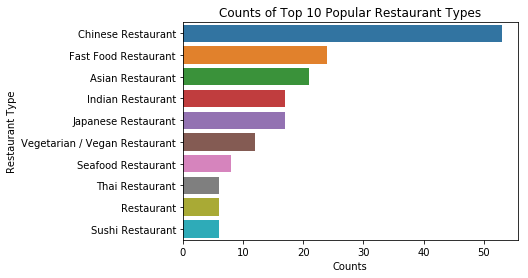

In [27]:
# Visualize the counts of the top 10 popular restaurant types

ax = sns.barplot(x='Counts',y="Restaurant Type", data=sg_FnBvenues_counts[:10])
plt.title("Counts of Top 10 Popular Restaurant Types")
plt.xlabel("Counts")


In [28]:
# Merge sg_FnBvenues and df_merge3

df_merge4 = df_merge3

# merge sg_fnbvenues_sorted with toronto_data to add latitude/longitude for each neighborhood
df_merge4 = df_merge4.join(sg_FnBvenues.set_index('Station Name'), on='Station Name')
df_merge4.head()

,Station Name,Towns,Existing Station Codes,Future Station Codes,Connecting Transport Interchange,Region,Town Area Coverage (km2),Population,Station(s) per Town,Crowd Density,Latitude,Longitude,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Chinese Garden,Jurong East,EW25,NaN,NaN,West,17.83,79240,2,2222.097588,1.342352821,103.7325967,1.342353,103.732597,Xing Yun Hainanese Boneless Chicken Rice,1.344723,103.733746,Asian Restaurant
0,Chinese Garden,Jurong East,EW25,NaN,NaN,West,17.83,79240,2,2222.097588,1.342352821,103.7325967,1.342353,103.732597,Joo Siah Bak Koot Teh 裕城肉骨茶,1.344726,103.733745,Chinese Restaurant
1,Jurong East,Jurong East,NS1 EW24,JE5,Jurong East Bus Interchange,West,17.83,79240,2,2222.097588,1.333152816,103.7422863,1.333153,103.742286,Tonkatsu by Ma Maison とんかつ マメゾン (Tonkatsu by M...,1.333668,103.742818,Japanese Restaurant
1,Jurong East,Jurong East,NS1 EW24,JE5,Jurong East Bus Interchange,West,17.83,79240,2,2222.097588,1.333152816,103.7422863,1.333153,103.742286,Dian Xiao Er 店小二 (Dian Xiao Er),1.333447,103.743094,Chinese Restaurant
1,Jurong East,Jurong East,NS1 EW24,JE5,Jurong East Bus Interchange,West,17.83,79240,2,2222.097588,1.333152816,103.7422863,1.333153,103.742286,Song Fa Bak Kut Teh 松發肉骨茶,1.333394,103.743420,Chinese Restaurant


In [29]:
# Drop columns that are not involved in subsequent analysis
df_merge4.drop(['Existing Station Codes','Future Station Codes','Connecting Transport Interchange','Station(s) per Town','Latitude','Longitude'],axis=1, inplace = True)
df_merge4.head()

,Station Name,Towns,Region,Town Area Coverage (km2),Population,Crowd Density,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Chinese Garden,Jurong East,West,17.83,79240,2222.097588,1.342353,103.732597,Xing Yun Hainanese Boneless Chicken Rice,1.344723,103.733746,Asian Restaurant
0,Chinese Garden,Jurong East,West,17.83,79240,2222.097588,1.342353,103.732597,Joo Siah Bak Koot Teh 裕城肉骨茶,1.344726,103.733745,Chinese Restaurant
1,Jurong East,Jurong East,West,17.83,79240,2222.097588,1.333153,103.742286,Tonkatsu by Ma Maison とんかつ マメゾン (Tonkatsu by M...,1.333668,103.742818,Japanese Restaurant
1,Jurong East,Jurong East,West,17.83,79240,2222.097588,1.333153,103.742286,Dian Xiao Er 店小二 (Dian Xiao Er),1.333447,103.743094,Chinese Restaurant
1,Jurong East,Jurong East,West,17.83,79240,2222.097588,1.333153,103.742286,Song Fa Bak Kut Teh 松發肉骨茶,1.333394,103.743420,Chinese Restaurant


#### Let's find out how many unique categories can be curated from all the returned venues

In [30]:
print('There are {} uniques categories.'.format(len(df_merge4['Venue Category'].unique())))

There are 33 uniques categories.


## Analyze locality of each MRT Station

In [31]:
# one hot encoding
df_merge4_onehot = pd.get_dummies(df_merge4[['Venue Category']], prefix="", prefix_sep="")

# add 'Station Name' column back to dataframe
df_merge4_onehot[['Station Name','Crowd Density']] = df_merge4[['Station Name','Crowd Density']] 

# move "Station Name" column to the first column
fixed_columns = list(df_merge4_onehot.columns[-2:]) + list(df_merge4_onehot.columns[:-2])
df_merge4_onehot = df_merge4_onehot[fixed_columns].reset_index(drop = True)

df_merge4_onehot

,Station Name,Crowd Density,American Restaurant,Asian Restaurant,Chinese Restaurant,Comfort Food Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Fast Food Restaurant,Filipino Restaurant,...,Portuguese Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Shaanxi Restaurant,Spanish Restaurant,Sushi Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Chinese Garden,2222.097588,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Chinese Garden,2222.097588,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Jurong East,2222.097588,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Jurong East,2222.097588,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Jurong East,2222.097588,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,Rochor,4117.283951,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
232,Jalan Besar,4117.283951,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
233,Jalan Besar,4117.283951,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
234,Jalan Besar,4117.283951,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size.

#### Next, let's group rows by Station Name and by taking the sum of occurrence of each category

In [32]:
df_merge4grp = df_merge4_onehot.groupby('Station Name').sum().reset_index()
df_merge4grp

,Station Name,Crowd Density,American Restaurant,Asian Restaurant,Chinese Restaurant,Comfort Food Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Fast Food Restaurant,Filipino Restaurant,...,Portuguese Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Shaanxi Restaurant,Spanish Restaurant,Sushi Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Admiralty,3748.785872,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Aljunied,8165.382336,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,2,0
2,Ang Mo Kio,11761.119082,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,Bayfront,179.065174,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Beauty World,4416.999430,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,Woodleigh,2953.488372,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93,Yew Tee,46863.338789,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
94,Yio Chu Kang,5880.559541,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95,Yishun,31118.644068,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


#### Let's confirm the new size

In [33]:
df_merge4grp.shape

(97, 34)

#### Let's print top 5 most common venues nearby each MRT Station 

In [34]:
num_top_venues = 5

for stn in df_merge4grp['Station Name']:
    print("----"+stn+" MRT Station"+"----")
    temp = df_merge4grp[df_merge4grp['Station Name'] == stn].T.reset_index()
    temp.columns = ['venue','sum']
    temp = temp.iloc[2:]
    temp['sum'] = temp['sum'].astype(int)
    #temp = temp.round({'freq': 3})
    print(temp.sort_values('sum', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Admiralty MRT Station----
                           venue  sum
0               Halal Restaurant    1
1            American Restaurant    0
2              Korean Restaurant    0
3  Vegetarian / Vegan Restaurant    0
4                Thai Restaurant    0


----Aljunied MRT Station----
                           venue  sum
0  Vegetarian / Vegan Restaurant    2
1             Seafood Restaurant    1
2             Chinese Restaurant    1
3            Japanese Restaurant    1
4               Ramen Restaurant    0


----Ang Mo Kio MRT Station----
                       venue  sum
0           Asian Restaurant    1
1       Fast Food Restaurant    1
2                 Restaurant    0
3           Malay Restaurant    0
4  Middle Eastern Restaurant    0


----Bayfront MRT Station----
                       venue  sum
0         Dim Sum Restaurant    1
1        Dumpling Restaurant    1
2        American Restaurant    0
3                 Restaurant    0
4  Middle Eastern Restaurant    0


----Beaut

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [35]:
def return_most_common_type(row, num_top_venues):
    row_categories = row.iloc[2:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 5 Restaurant venues nearby every MRT Station

In [36]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Station Name','Crowd Density']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Restaurant Type'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Restaurant Type'.format(ind+1))

# create a new dataframe to store 
df_merge4sort = pd.DataFrame(columns=columns)
df_merge4sort[['Station Name','Crowd Density']] = df_merge4grp[['Station Name','Crowd Density']]

for ind in np.arange(df_merge4grp.shape[0]):
    df_merge4sort.iloc[ind, 2:] = return_most_common_type(df_merge4grp.iloc[ind, 2:], num_top_venues)

df_merge4sort.head()

,Station Name,Crowd Density,1st Most Common Restaurant Type,2nd Most Common Restaurant Type,3rd Most Common Restaurant Type,4th Most Common Restaurant Type,5th Most Common Restaurant Type
0,Admiralty,3748.785872,Halal Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Comfort Food Restaurant,Dim Sum Restaurant
1,Aljunied,8165.382336,Vegetarian / Vegan Restaurant,Chinese Restaurant,Japanese Restaurant,Seafood Restaurant,Comfort Food Restaurant
2,Ang Mo Kio,11761.119082,Fast Food Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Comfort Food Restaurant,Dim Sum Restaurant
3,Bayfront,179.065174,Dim Sum Restaurant,Dumpling Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Comfort Food Restaurant
4,Beauty World,4416.999430,Chinese Restaurant,Indian Restaurant,Korean Restaurant,Japanese Restaurant,Comfort Food Restaurant


## Cluster MRT Stations

Run *k*-means to cluster the MRT Stations into 5 clusters.

In [37]:
# set number of clusters
kclusters = 5

df_merge4cluster = df_merge4grp.drop('Station Name', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_merge4cluster)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:30]

array([4, 0, 0, 4, 4, 0, 4, 4, 4, 3, 0, 3, 0, 3, 0, 3, 3, 4, 4, 4, 4, 1,
       4, 2, 4, 1, 4, 4, 4, 4], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 5 venues near each mrt station

In [38]:
# add clustering labels
df_merge4grp['Cluster Labels'] = pd.Series(kmeans.labels_,index=df_merge4grp.index)
df_merge5 = pd.merge(left=df_merge4sort, right=df_merge4grp.drop(['Crowd Density'],axis=1), left_on = 'Station Name', right_on = 'Station Name')
# Merge sg_merge4sort with sg_merge4
df_merge6 = pd.merge(left=df_merge5, right = df_merge4[['Station Name','Towns','Station Latitude','Station Longitude']], left_on = 'Station Name', right_on = 'Station Name')
df_merge6 = df_merge6.dropna(subset=['Station Latitude','Station Longitude'])
df_merge6.head()

,Station Name,Crowd Density,1st Most Common Restaurant Type,2nd Most Common Restaurant Type,3rd Most Common Restaurant Type,4th Most Common Restaurant Type,5th Most Common Restaurant Type,American Restaurant,Asian Restaurant,Chinese Restaurant,...,Shaanxi Restaurant,Spanish Restaurant,Sushi Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Cluster Labels,Towns,Station Latitude,Station Longitude
0,Admiralty,3748.785872,Halal Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Comfort Food Restaurant,Dim Sum Restaurant,0,0,0,...,0,0,0,0,0,0,4,Woodlands,1.440589,103.800990
1,Aljunied,8165.382336,Vegetarian / Vegan Restaurant,Chinese Restaurant,Japanese Restaurant,Seafood Restaurant,Comfort Food Restaurant,0,0,1,...,0,0,0,0,2,0,0,Geylang,1.316433,103.882906
2,Aljunied,8165.382336,Vegetarian / Vegan Restaurant,Chinese Restaurant,Japanese Restaurant,Seafood Restaurant,Comfort Food Restaurant,0,0,1,...,0,0,0,0,2,0,0,Geylang,1.316433,103.882906
3,Aljunied,8165.382336,Vegetarian / Vegan Restaurant,Chinese Restaurant,Japanese Restaurant,Seafood Restaurant,Comfort Food Restaurant,0,0,1,...,0,0,0,0,2,0,0,Geylang,1.316433,103.882906
4,Aljunied,8165.382336,Vegetarian / Vegan Restaurant,Chinese Restaurant,Japanese Restaurant,Seafood Restaurant,Comfort Food Restaurant,0,0,1,...,0,0,0,0,2,0,0,Geylang,1.316433,103.882906


In [39]:
# Rearrange Columns to move forward Towns, Station Latitude and Station Longtitude
_, cols = df_merge6.shape
fixed_columns = [df_merge6.columns[0]]+list(df_merge6.columns[cols-3:cols])+list(df_merge6.columns[1:cols-3])
df_merge6 = df_merge6[fixed_columns].reset_index(drop = True)
df_merge6.head()

,Station Name,Towns,Station Latitude,Station Longitude,Crowd Density,1st Most Common Restaurant Type,2nd Most Common Restaurant Type,3rd Most Common Restaurant Type,4th Most Common Restaurant Type,5th Most Common Restaurant Type,...,Ramen Restaurant,Restaurant,Seafood Restaurant,Shaanxi Restaurant,Spanish Restaurant,Sushi Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Cluster Labels
0,Admiralty,Woodlands,1.440589,103.800990,3748.785872,Halal Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Comfort Food Restaurant,Dim Sum Restaurant,...,0,0,0,0,0,0,0,0,0,4
1,Aljunied,Geylang,1.316433,103.882906,8165.382336,Vegetarian / Vegan Restaurant,Chinese Restaurant,Japanese Restaurant,Seafood Restaurant,Comfort Food Restaurant,...,0,0,1,0,0,0,0,2,0,0
2,Aljunied,Geylang,1.316433,103.882906,8165.382336,Vegetarian / Vegan Restaurant,Chinese Restaurant,Japanese Restaurant,Seafood Restaurant,Comfort Food Restaurant,...,0,0,1,0,0,0,0,2,0,0
3,Aljunied,Geylang,1.316433,103.882906,8165.382336,Vegetarian / Vegan Restaurant,Chinese Restaurant,Japanese Restaurant,Seafood Restaurant,Comfort Food Restaurant,...,0,0,1,0,0,0,0,2,0,0
4,Aljunied,Geylang,1.316433,103.882906,8165.382336,Vegetarian / Vegan Restaurant,Chinese Restaurant,Japanese Restaurant,Seafood Restaurant,Comfort Food Restaurant,...,0,0,1,0,0,0,0,2,0,0


##### Exploring relationship between counts of restaurant type and Crowd Density

In [76]:
import scipy.stats as scp

# Create dataframe to contain pearson p-value for all restaurant types correlating to Crowd Density
x = pd.Series(df_merge6['Crowd Density'])
col_heads = ['Restaurant Type','Pearson Correlaton']
restaurantTypes = list(df_merge6.columns[10:cols-1])
pVal =[]
dict_pear = {'Restaurant Type': restaurantTypes, 'p_value':pVal}

for rstType in restaurantTypes:
    y = pd.Series(df_merge6[rstType])
    pVal.append(scp.pearsonr(x,y)[0])
    
df_pear = pd.DataFrame(dict_pear)

df_pear_sort = df_pear.sort_values(by='p_value',ascending=False)

# Extract top 10 most common Restaurant type
top10list=list(sg_FnBvenues_counts[:10]['Restaurant Type'])

#Show pearson correlation p-value for top 10 most common restaurant type
df_pear_sort.loc[df_pear_sort['Restaurant Type'].isin(top10list)]

,Restaurant Type,p_value
29,Thai Restaurant,0.360426
28,Sushi Restaurant,0.291626
6,Fast Food Restaurant,0.271617
2,Chinese Restaurant,0.181349
25,Seafood Restaurant,0.056789
1,Asian Restaurant,0.011385
24,Restaurant,0.001572
13,Indian Restaurant,-0.000178
30,Vegetarian / Vegan Restaurant,-0.078464
15,Japanese Restaurant,-0.105755


#### Visualizing the K-Mean Clustering Results

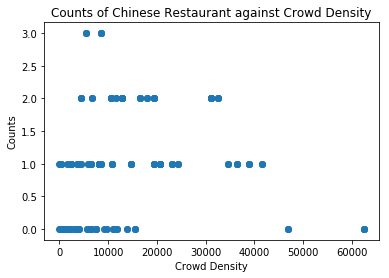

In [108]:
x = pd.Series(df_merge6['Crowd Density'])
y = pd.Series(df_merge6['Chinese Restaurant'])
plt.scatter(x,y)
plt.xlabel('Crowd Density')
plt.ylabel('Counts')
plt.title('Counts of Chinese Restaurant against Crowd Density')
plt.show()

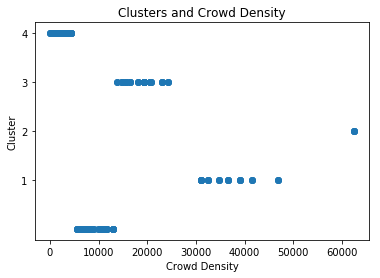

In [109]:
x = pd.Series(df_merge6['Crowd Density'])
y = pd.Series(df_merge6['Cluster Labels'])
plt.scatter(x,y)
plt.ylabel('Cluster')
plt.xlabel('Crowd Density')
plt.title('Clusters and Crowd Density')
plt.yticks(np.arange(min(y)+1, max(y)+1, 1.0))
plt.show()

In [42]:
# create map
map_clusters = folium.Map(location=[sg_latitude, sg_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merge6['Station Latitude'], df_merge6['Station Longitude'], df_merge6['Station Name'], df_merge6['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [79]:
# Create a subset dataframe from df_merge6 to be used for examining each cluster
df_merge6grp = df_merge6[['Station Name',
                         'Station Latitude',
                         'Station Longitude',
                         'Crowd Density',
                          'Cluster Labels',
                         '1st Most Common Restaurant Type',
                         '2nd Most Common Restaurant Type',
                         '3rd Most Common Restaurant Type',
                         '4th Most Common Restaurant Type',
                         '5th Most Common Restaurant Type',
                        ]].groupby(df_merge6['Cluster Labels'])
df_merge6grp.head(20)

,Station Name,Station Latitude,Station Longitude,Crowd Density,Cluster Labels,1st Most Common Restaurant Type,2nd Most Common Restaurant Type,3rd Most Common Restaurant Type,4th Most Common Restaurant Type,5th Most Common Restaurant Type
0,Admiralty,1.440589,103.800990,3748.785872,4,Halal Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Comfort Food Restaurant,Dim Sum Restaurant
1,Aljunied,1.316433,103.882906,8165.382336,0,Vegetarian / Vegan Restaurant,Chinese Restaurant,Japanese Restaurant,Seafood Restaurant,Comfort Food Restaurant
2,Aljunied,1.316433,103.882906,8165.382336,0,Vegetarian / Vegan Restaurant,Chinese Restaurant,Japanese Restaurant,Seafood Restaurant,Comfort Food Restaurant
3,Aljunied,1.316433,103.882906,8165.382336,0,Vegetarian / Vegan Restaurant,Chinese Restaurant,Japanese Restaurant,Seafood Restaurant,Comfort Food Restaurant
4,Aljunied,1.316433,103.882906,8165.382336,0,Vegetarian / Vegan Restaurant,Chinese Restaurant,Japanese Restaurant,Seafood Restaurant,Comfort Food Restaurant
...,...,...,...,...,...,...,...,...,...,...
171,Sengkang,1.391695,103.895485,34645.892351,1,Chinese Restaurant,Sushi Restaurant,Fast Food Restaurant,Japanese Restaurant,Comfort Food Restaurant
172,Sengkang,1.391695,103.895485,34645.892351,1,Chinese Restaurant,Sushi Restaurant,Fast Food Restaurant,Japanese Restaurant,Comfort Food Restaurant
173,Sengkang,1.391695,103.895485,34645.892351,1,Chinese Restaurant,Sushi Restaurant,Fast Food Restaurant,Japanese Restaurant,Comfort Food Restaurant
207,Yew Tee,1.397535,103.747405,46863.338789,1,Fast Food Restaurant,Japanese Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Comfort Food Restaurant


## Examine Clusters

Examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

### Cluster 1

In [80]:
df_cl1 = df_merge6grp.get_group(0).drop_duplicates()
print(f"n = {df_cl1.shape[0]}")
df_cl1.sort_values(by='Crowd Density',ascending=False).reset_index(drop=True)


n = 23


,Station Name,Station Latitude,Station Longitude,Crowd Density,Cluster Labels,1st Most Common Restaurant Type,2nd Most Common Restaurant Type,3rd Most Common Restaurant Type,4th Most Common Restaurant Type,5th Most Common Restaurant Type
0,Bedok,1.323980,103.929985,12880.590134,0,Chinese Restaurant,Vegetarian / Vegan Restaurant,Fast Food Restaurant,French Restaurant,Hotpot Restaurant
1,Ang Mo Kio,1.369933,103.849558,11761.119082,0,Fast Food Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Comfort Food Restaurant,Dim Sum Restaurant
2,Buangkok,1.382870,103.893123,11548.630784,0,Fast Food Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Comfort Food Restaurant,Dim Sum Restaurant
3,Serangoon,1.350634,103.872772,11515.841584,0,Chinese Restaurant,Vegetarian / Vegan Restaurant,Comfort Food Restaurant,Dim Sum Restaurant,Dumpling Restaurant
4,Novena,1.320441,103.843826,10959.910913,0,Restaurant,Ramen Restaurant,Vietnamese Restaurant,Japanese Restaurant,Comfort Food Restaurant
5,Kembangan,1.321038,103.912948,10733.825111,0,Indian Restaurant,Chinese Restaurant,Vegetarian / Vegan Restaurant,Comfort Food Restaurant,Dim Sum Restaurant
6,Tiong Bahru,1.286103,103.827445,10598.326360,0,Chinese Restaurant,Sushi Restaurant,Fast Food Restaurant,Hainan Restaurant,Japanese Restaurant
7,Pasir Ris,1.373043,103.949285,9854.860186,0,Fast Food Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Comfort Food Restaurant,Dim Sum Restaurant
8,Riviera,1.394520,103.916169,9130.620985,0,Fast Food Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Comfort Food Restaurant,Dim Sum Restaurant
9,Labrador Park,1.272254,103.802632,8478.661088,0,Chinese Restaurant,Japanese Restaurant,Sushi Restaurant,Fast Food Restaurant,Comfort Food Restaurant


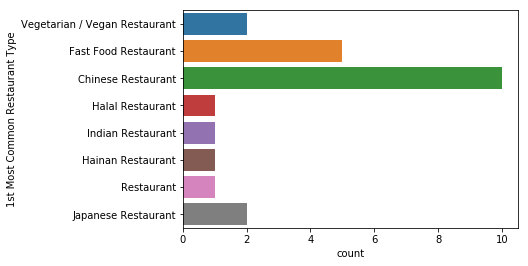

In [81]:
ax1_1 = sns.countplot(y='1st Most Common Restaurant Type', data=df_cl1)


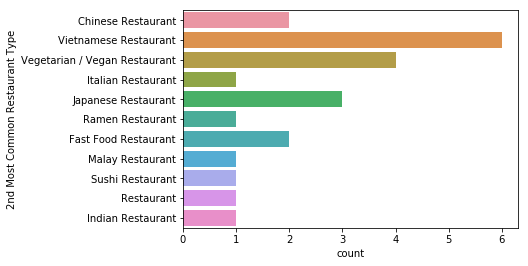

In [82]:
ax1_2 = sns.countplot(y='2nd Most Common Restaurant Type', data=df_cl1)

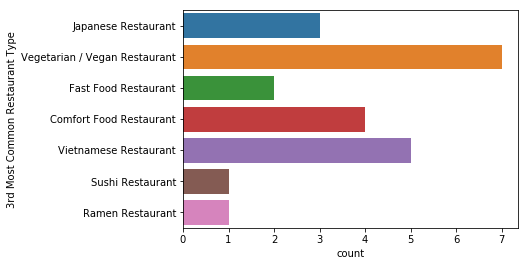

In [83]:
ax1_3 = sns.countplot(y='3rd Most Common Restaurant Type', data=df_cl1)

### Cluster 2

In [84]:
df_cl2 = df_merge6grp.get_group(1).drop_duplicates()
print(f"n = {df_cl2.shape[0]}")
df_cl2.sort_values(by='Crowd Density',ascending=False).reset_index(drop=True)

n = 7


,Station Name,Station Latitude,Station Longitude,Crowd Density,Cluster Labels,1st Most Common Restaurant Type,2nd Most Common Restaurant Type,3rd Most Common Restaurant Type,4th Most Common Restaurant Type,5th Most Common Restaurant Type
0,Yew Tee,1.397535,103.747405,46863.338789,1,Fast Food Restaurant,Japanese Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Comfort Food Restaurant
1,Chinatown,1.284224,103.845144,41518.248175,1,Chinese Restaurant,Dumpling Restaurant,Restaurant,Japanese Restaurant,Comfort Food Restaurant
2,Clementi,1.315116,103.765192,38954.689146,1,Chinese Restaurant,Thai Restaurant,Dim Sum Restaurant,Italian Restaurant,Japanese Restaurant
3,Punggol,1.404547,103.902073,36522.483940,1,Vietnamese Restaurant,Sushi Restaurant,Seafood Restaurant,Chinese Restaurant,Spanish Restaurant
4,Sengkang,1.391695,103.895485,34645.892351,1,Chinese Restaurant,Sushi Restaurant,Fast Food Restaurant,Japanese Restaurant,Comfort Food Restaurant
5,Kovan,1.360179,103.885065,32482.412060,1,Chinese Restaurant,Korean Restaurant,Japanese Restaurant,Comfort Food Restaurant,Dim Sum Restaurant
6,Yishun,1.429443,103.835005,31118.644068,1,Chinese Restaurant,Sushi Restaurant,Hainan Restaurant,Halal Restaurant,Indian Restaurant


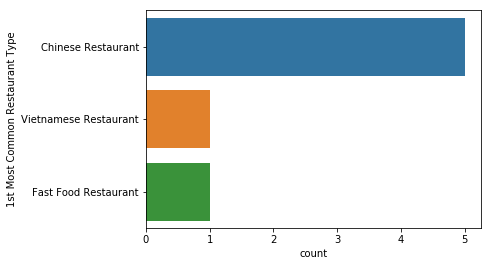

In [85]:
ax2_1 = sns.countplot(y='1st Most Common Restaurant Type', data=df_cl2)

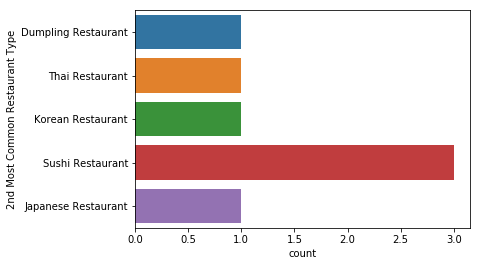

In [86]:
ax2_2 = sns.countplot(y='2nd Most Common Restaurant Type', data=df_cl2)

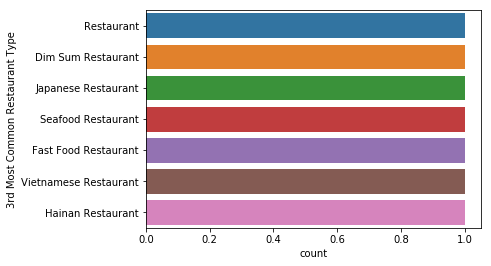

In [87]:
ax2_3 = sns.countplot(y='3rd Most Common Restaurant Type', data=df_cl2)

### Cluster 3

In [88]:
df_cl3 = df_merge6grp.get_group(2).drop_duplicates()
print(f"n = {df_cl3.shape[0]}")
df_cl3.sort_values(by='Crowd Density',ascending=False).reset_index(drop=True)

n = 1


,Station Name,Station Latitude,Station Longitude,Crowd Density,Cluster Labels,1st Most Common Restaurant Type,2nd Most Common Restaurant Type,3rd Most Common Restaurant Type,4th Most Common Restaurant Type,5th Most Common Restaurant Type
0,Choa Chu Kang,1.385363,103.744371,62484.451718,2,Thai Restaurant,Fast Food Restaurant,Portuguese Restaurant,Vietnamese Restaurant,Japanese Restaurant


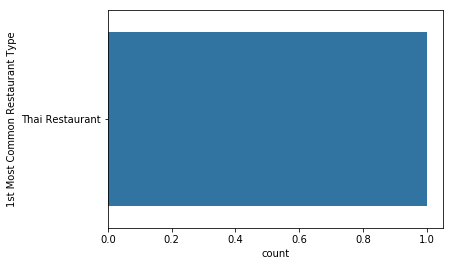

In [89]:
ax3_1 = sns.countplot(y='1st Most Common Restaurant Type', data=df_cl3)

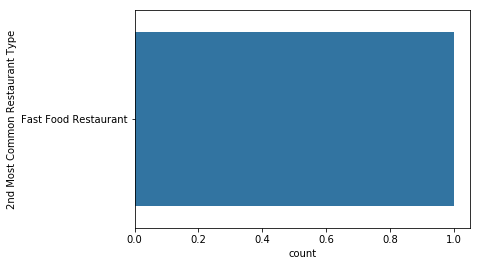

In [90]:
ax3_2 = sns.countplot(y='2nd Most Common Restaurant Type', data=df_cl3)

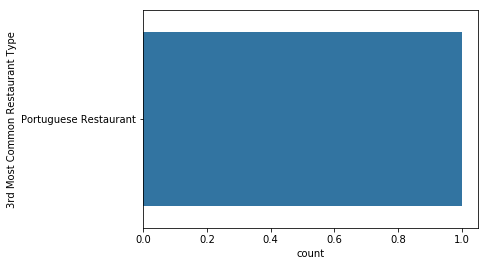

In [91]:
ax3_3 = sns.countplot(y='3rd Most Common Restaurant Type', data=df_cl3)

### Cluster 4

In [92]:
df_cl4 = df_merge6grp.get_group(3).drop_duplicates()
print(f"n = {df_cl4.shape[0]}")
df_cl4.sort_values(by='Crowd Density',ascending=False).reset_index(drop=True)

n = 11


,Station Name,Station Latitude,Station Longitude,Crowd Density,Cluster Labels,1st Most Common Restaurant Type,2nd Most Common Restaurant Type,3rd Most Common Restaurant Type,4th Most Common Restaurant Type,5th Most Common Restaurant Type
0,Hougang,1.371292,103.892381,24361.809045,3,Chinese Restaurant,Thai Restaurant,Fast Food Restaurant,Japanese Restaurant,Comfort Food Restaurant
1,Bishan,1.351316,103.849140,23099.737533,3,Chinese Restaurant,Japanese Restaurant,Dumpling Restaurant,Shaanxi Restaurant,Comfort Food Restaurant
2,Bukit Gombak,1.358612,103.751791,20719.676550,3,Chinese Restaurant,Malay Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Comfort Food Restaurant
3,Rochor,1.303852,103.852769,20586.419753,3,Indian Restaurant,Chinese Restaurant,Vegetarian / Vegan Restaurant,Comfort Food Restaurant,Dim Sum Restaurant
4,Sembawang,1.449051,103.820046,19432.739060,3,Fast Food Restaurant,Chinese Restaurant,Japanese Restaurant,Sushi Restaurant,Comfort Food Restaurant
5,Newton,1.313993,103.837715,19396.135266,3,Chinese Restaurant,Thai Restaurant,Seafood Restaurant,Japanese Restaurant,Comfort Food Restaurant
6,Boon Lay,1.338604,103.706065,18029.952349,3,Chinese Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Comfort Food Restaurant,Dim Sum Restaurant
7,Jalan Besar,1.305171,103.855296,16469.135802,3,Chinese Restaurant,Vegetarian / Vegan Restaurant,Indian Restaurant,Comfort Food Restaurant,Dim Sum Restaurant
8,Khatib,1.417383,103.832980,15559.322034,3,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Comfort Food Restaurant,Dim Sum Restaurant,Dumpling Restaurant
9,Braddell,1.340469,103.846799,14767.441860,3,Seafood Restaurant,Chinese Restaurant,Japanese Restaurant,Comfort Food Restaurant,Dim Sum Restaurant


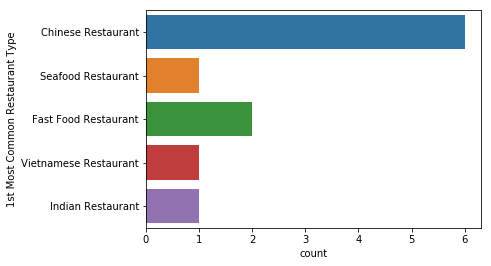

In [93]:
ax4_1 = sns.countplot(y='1st Most Common Restaurant Type', data=df_cl4)

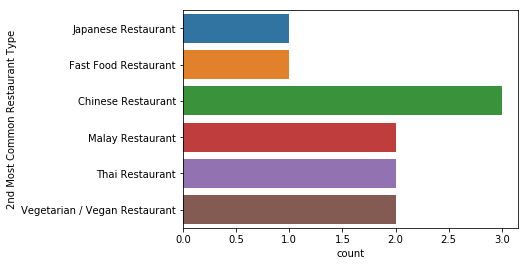

In [94]:
ax4_2 = sns.countplot(y='2nd Most Common Restaurant Type', data=df_cl4)

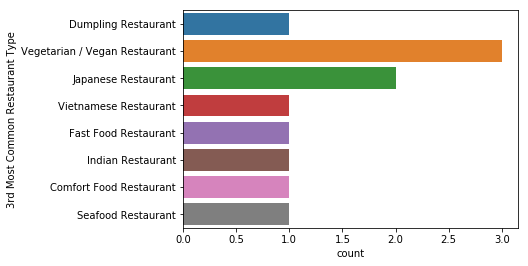

In [95]:
ax4_3 = sns.countplot(y='3rd Most Common Restaurant Type', data=df_cl4)

### Cluster 5

In [96]:
df_cl5 = df_merge6grp.get_group(4).drop_duplicates()
print(f"n = {df_cl5.shape[0]}")
df_cl5.sort_values(by='Crowd Density',ascending=False).reset_index(drop=True)

n = 39


,Station Name,Station Latitude,Station Longitude,Crowd Density,Cluster Labels,1st Most Common Restaurant Type,2nd Most Common Restaurant Type,3rd Most Common Restaurant Type,4th Most Common Restaurant Type,5th Most Common Restaurant Type
0,Chinese Garden,1.342353,103.732597,4444.195177,4,Chinese Restaurant,Vegetarian / Vegan Restaurant,Comfort Food Restaurant,Dim Sum Restaurant,Dumpling Restaurant
1,Beauty World,1.341223,103.775794,4416.999430,4,Chinese Restaurant,Indian Restaurant,Korean Restaurant,Japanese Restaurant,Comfort Food Restaurant
2,Tampines West,1.345515,103.938437,4096.537418,4,Vegetarian / Vegan Restaurant,Halal Restaurant,Vietnamese Restaurant,Comfort Food Restaurant,Dim Sum Restaurant
3,Expo,1.334550,103.961548,4096.537418,4,Chinese Restaurant,Filipino Restaurant,Vegetarian / Vegan Restaurant,Comfort Food Restaurant,Dim Sum Restaurant
4,Tampines,1.355150,103.943010,4096.537418,4,Chinese Restaurant,Thai Restaurant,Japanese Restaurant,Comfort Food Restaurant,Dim Sum Restaurant
5,Admiralty,1.440589,103.800990,3748.785872,4,Halal Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Comfort Food Restaurant,Dim Sum Restaurant
6,Kallang,1.311489,103.871386,3690.294438,4,Chinese Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,Comfort Food Restaurant,Dim Sum Restaurant
7,Bendemeer,1.313673,103.862978,3690.294438,4,Restaurant,Vietnamese Restaurant,Japanese Restaurant,Comfort Food Restaurant,Dim Sum Restaurant
8,Lavender,1.307378,103.862768,3690.294438,4,Vietnamese Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Comfort Food Restaurant,Dim Sum Restaurant
9,Tan Kah Kee,1.325556,103.807760,3312.749572,4,Spanish Restaurant,French Restaurant,Vietnamese Restaurant,Japanese Restaurant,Comfort Food Restaurant


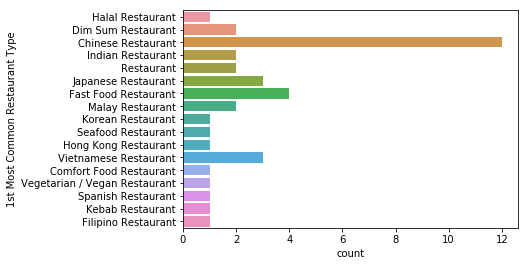

In [97]:
ax5_1 = sns.countplot(y='1st Most Common Restaurant Type', data=df_cl5)

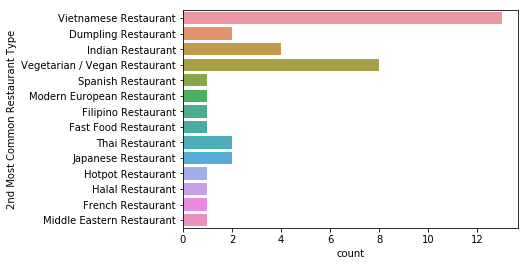

In [98]:
ax5_2 = sns.countplot(y='2nd Most Common Restaurant Type', data=df_cl5)

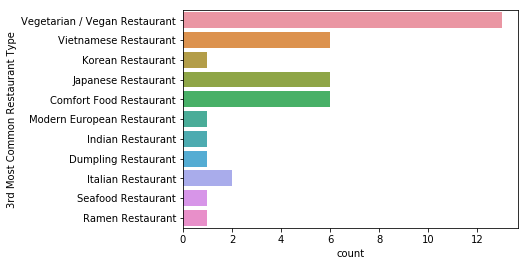

In [99]:
ax5_3 = sns.countplot(y='3rd Most Common Restaurant Type', data=df_cl5)

##### Exploring Relationship between Clusters and Crowd Density

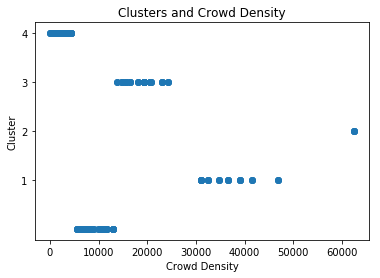

#### The End